In [3]:
# import functions used in developing and testing SOFA-LR
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc, font_manager
from sklearn import metrics
import numpy as np
from sklearn import linear_model
# from sklearn.svm import l1_min_cs
import pandas as pd
import seaborn as sns
from random import sample
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from random import choices
import matplotlib.colors as mcolors
from scipy import interpolate
from tqdm import tqdm
from matplotlib.font_manager import FontProperties
from scipy.stats import zscore

In [4]:
y = pd.read_csv("ydata.csv")
y = np.array(y,dtype='float')
y = y[:,1]

df = pd.read_csv("Xdata_non.csv")
df = df.iloc[:,1:]

df = df.loc[:, ['Age', 'SexDSC', 'GCS', 'PaO2_FiO2',
       'mech_vent_cpap', 'Total_Bilirubin_mg_per_dL', 'Platelets_10_3_per_ml',
       'Creatinine_mg_per_dL', 'Urine_output_mL', 'MAP', 'Dobutamine_any_dose',
       'Dopamine_μg_kg_min', 'Epinephrine_μg_kg_min',
       'Norepinephrine_μg_kg_min']]

In [5]:
# create a isnan_df1 full of 0s/1s  - 0 is not a nan, 1 is a nan
isnan_df = np.isnan(df)

# concatenate the arrays to have pairs of cols to show which are missing.
X = pd.DataFrame(np.concatenate((df.loc[:, ['Age', 'SexDSC', 'GCS', 'PaO2_FiO2',
       'mech_vent_cpap', 'Total_Bilirubin_mg_per_dL', 'Platelets_10_3_per_ml',
       'Creatinine_mg_per_dL', 'Urine_output_mL', 'MAP', 'Dobutamine_any_dose',
       'Dopamine_μg_kg_min', 'Epinephrine_μg_kg_min',
       'Norepinephrine_μg_kg_min']].to_numpy(), isnan_df[["GCS", "PaO2_FiO2", "Total_Bilirubin_mg_per_dL", "Platelets_10_3_per_ml", "Creatinine_mg_per_dL", "Urine_output_mL", "MAP"]].to_numpy()), axis = 1))
X = X.fillna(0)
x = X.iloc[:,0]

# normalize columns of X
X_norm = X.apply(zscore)
X_norm = np.array(X_norm,dtype='float')

# OG_X is not normalized data, and has only the SOFA components
OG_X = df

In [6]:
# check shapes of the 3 X variables
print(X.shape)       # (37739, 21)
print(X_norm.shape)  # (37739, 21)
print(OG_X.shape)    # (37739, 14)

(37739, 21)
(37739, 21)
(37739, 14)


In [7]:
# split X and y into training and testing sets (50% for training, 50% for testing)
indices = np.arange(X_norm.shape[0])
X_train, X_test, y_train, y_test, OG_X_train, OG_X_test, indices_train, indices_test = \
    train_test_split(X_norm, y, OG_X, indices, \
    test_size=0.5, random_state=16)

In [8]:
# function to calculate SOFA score
def calc_sofa(components):
    sub_scr = np.zeros(6)
    # coagulation
    c = 0
    x = components["Platelets_10_3_per_ml"]
    if (x > 150) or np.isnan(x):
        c = 0
    elif (x > 100): 
        c = 1
    elif (x > 50): # removed =
        c = 2
    elif (x > 20): # removed =
        c = 3
    else:
        c = 4
    sub_scr[0] = c
    
    # liver
    c = 0
    x = components["Total_Bilirubin_mg_per_dL"]
    if (x < 1.2) or np.isnan(x):
        c = 0
    elif (x <= 1.9):
        c = 1
    elif (x < 6):
        c = 2
    elif (x < 12):
        c = 3
    else:
        c = 4
    sub_scr[1] = c
    
    # GCS
    c = 0
    x = components["GCS"]
    #if (x > 1) or np.isnan(x):
    if (x > 14) or np.isnan(x): # added
        c = 0
    elif (x > 12):
        c = 1
    elif (x > 9):
        c = 2
    elif (x > 5):
        c = 3
    else:
        c = 4
    sub_scr[2] = c
    
    # renal
    c = 0
    x = components["Creatinine_mg_per_dL"]
    u = components["Urine_output_mL"] # added
    # if (x < 1.2) or np.isnan(x):
    if (x < 1.2):  # added
        c = 0
    elif (x < 2):
        c = 1
    elif (x < 3.5):
        c = 2
    #elif (x < 5):
    elif (x < 5) or (u < 500):     # added  
        c = 3
    # else:
    elif (x >= 5) or (u < 200):     # added
        c = 4
    else:              
        c = 0          # added
    sub_scr[3] = c

    # Cardiovascular
    c = 0
    MAP = components["MAP"]
    n = components["Norepinephrine_μg_kg_min"]
    e = components["Epinephrine_μg_kg_min"]
    dobute = components["Dobutamine_any_dose"]
    dope = components["Dopamine_μg_kg_min"]
    # if np.isnan(MAP) or np.isnan(n) or np.isnan(e) or np.isnan(dobute) or np.isnan(dope):
    if np.isnan(MAP) and np.isnan(n) and np.isnan(e) and np.isnan(dobute) and np.isnan(dope): # added
        c = 0
    elif (dope > 15 or e > 0.1 or n > 0.1):
        c = 4
    elif (dope > 5 or (e < 0.1 and e > 0) or (n < 0.1 and n > 0)):
        c = 3
    elif ((dope <= 5 and dope > 0) or dobute > 0):
        c = 2
    elif (MAP < 70):
        c = 1
    else:
        c = 0
    sub_scr[4] = c
    
    # respiratory
    c = 0
    p = components["PaO2_FiO2"]
    v = components["mech_vent_cpap"]
    
    if (p < 100) and (v==1): # added
        c = 4
    elif (p < 200) and (v==1): # added
        c = 3
    elif (p < 300):
        c = 2
    elif (p < 400):
        c = 1
    else:
        c = 0
    sub_scr[5] = c
    
    sofa_scr = 0
    for i in range(0, len(sub_scr)):
        sofa_scr += sub_scr[i]
        
    return sofa_scr

In [9]:
# function to do median imputation for SOFA scores
def median_impute(dataframe, medians):
    temp_df = dataframe.copy()
    sofas = np.zeros(temp_df.shape[0])
    for i in tqdm(range(dataframe.shape[0])):
        for j in range(dataframe.shape[1]):
            if np.isnan(dataframe.iloc[i, j]):    
                temp_df.iloc[i, j] = medians.iloc[j, 0]
        sofas[i] = calc_sofa(temp_df.iloc[i, :])
    return sofas

In [10]:
# get SOFA scores - do median imputation for missing values 
medians = pd.DataFrame(OG_X_train.median())
sofas_median = median_impute(OG_X, medians)
sofas_median = sofas_median.reshape(len(sofas_median), 1)

100%|███████████████████████████████████| 37739/37739 [00:21<00:00, 1762.87it/s]


In [11]:
# X2 is un-normalized data, only Age, Sex, and SOFA score. Will be used for the SOFA+Age+Sex model
X2 = df.loc[:,['Age','SexDSC']]
X2["SOFA_Score"] = sofas_median
X2 = np.array(X2,dtype='float')

In [12]:
# split X2 in exactly the same way as X, OG_X, y
X2_train, X2_test, sofas_train, sofas_test, indices_train2, indices_test2 = \
    train_test_split(X2, sofas_median, indices, \
    test_size=0.5, random_state=16)

In [13]:
# test the SOFA-LR model -- get items needed for ROC curve
def LogRegressTest(X_test, y_test,N,model):
    pred = model.predict_proba(X_test)[::,1]
    
    #------ ROC CURVE ---------------
    th = np.arange(-.01, 1.1,0.01)
    tpr = np.zeros((1,N))
    fpr = np.zeros((1,N))

    for i in range(len(th)):
        tp = np.sum(np.logical_and(pred>th[i], y_test==1))
        fp = np.sum(np.logical_and(pred>th[i], y_test==0))
        tn = np.sum(np.logical_and(pred<=th[i], y_test==0))
        fn = np.sum(np.logical_and(pred<=th[i], y_test==1))

        tpr[0,i] = tp/(tp+fn)
        fpr[0,i] = fp/(fp+tn)
    
    auc = metrics.roc_auc_score(y_test, pred)
    return pred, fpr, tpr, auc

In [14]:
# get bootstrap confidence intervals for ROC curve
def ROC_confidenceBands(X_test, nb, N, model):
    # Get bootstrapped confidence intervals for fancy logistic regression model
    inds = list(range(1, X_test.shape[0]))
    tpr = np.zeros((nb,N))

    for i in range(nb):
        bootstrap_inds = np.random.choice(inds, size=len(inds), replace=True)
        pred, fpr0, tpr0, auc = LogRegressTest(X_test[bootstrap_inds,:], y_test[bootstrap_inds],N,model)
        tpr0 = np.asarray(tpr0).squeeze()
        fpr0 = np.asarray(fpr0).squeeze()
        f = interpolate.interp1d(fpr0, tpr0)
        xx = np.linspace(start=0, stop=1, num=N)
        tpr[i,:] = f(xx)
        
    # get 95% confidence interval (L,U) and median M
    U = np.percentile(tpr, 97.5,axis =0)
    L = np.percentile(tpr, 2.5,axis =0)
    M = np.percentile(tpr, 50,axis =0)
    
    return L,M,U,xx

In [15]:
# train SOFA-LR model
y_train_original = y_train

clf0 = LogisticRegressionCV(cv = 5, refit=True, penalty = 'l1', solver = 'liblinear',random_state = 0).fit(X_train, y_train)
c = clf0.coef_.flatten() # model coefficients (for Figure 2)

# get ROC curve
N = 1000 # the number of points along the ROC curve
pred0, fpr0, tpr0, auc0 = LogRegressTest(X_test, y_test, N, clf0)

# get 95% confidence band for ROC curve
nb = 1000 # the number of bootstrap confidence intervals
L0,M0,U0,xx = ROC_confidenceBands(X_test,nb,N,clf0)

In [16]:
# train the model with just SOFA
clf1 = LogisticRegressionCV(cv = 5, refit=True, penalty = 'l1', solver = 'liblinear',random_state = 0).fit(sofas_train, y_train_original)

# test the sofa model
pred1, fpr1, tpr1, auc1 = LogRegressTest(sofas_test, y_test, N, clf1)

# # get 95% confidence interval for ROC curve
L1,M1,U1,xx = ROC_confidenceBands(sofas_test, nb, N, clf1)

In [17]:
# train the logistic regression model that includes SOFA + Age + Sex

# train the logistic regression model
clf2 = LogisticRegressionCV(cv = 5, refit=True, penalty = 'l1', solver = 'liblinear',random_state = 0).fit(X2_train, y_train_original)

# get ROC curve
pred2, fpr2, tpr2, auc2 = LogRegressTest(X2_test, y_test, N, clf2)

# get 95% confidence interval for ROC curve
L2,M2,U2,xx = ROC_confidenceBands(X2_test,nb,N,clf2)

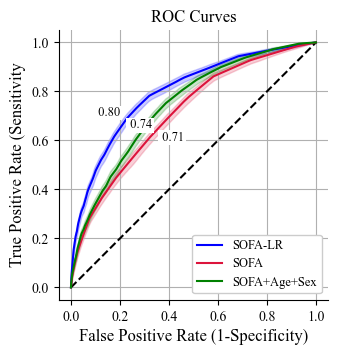

In [18]:
# Figure 1A: plot the ROC curves with 95% confidence interval (estimated by bootstrapping)

fpr = xx
fig, ax = plt.subplots(figsize=(3.5, 3.5)) # size is in inches

font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')

# SOFA-LR
lines = ax.plot(fpr, M0, 'b', label='SOFA-LR')
l1 = lines[0]
ax.plot(fpr,fpr,'k--')
ax.fill_between(fpr, L0, U0, alpha=0.2, color = 'b')

# SOFA
lines = ax.plot(fpr, M1, 'crimson', label='SOFA')
l2 = lines[0]
ax.fill_between(fpr, L1, U1, alpha=0.2, color = 'crimson')

# SOFA+Age+Sex
lines = ax.plot(fpr, M2, 'g', label='SOFA+Age+Sex')
l3 = lines[0]
ax.fill_between(fpr, L2, U2, alpha=0.2, color = 'g')


# add AUROC values
s = f" {auc0:.2f}"
plt.text(0.1, 0.7, s, fontsize=9, fontproperties=font, 
         bbox={'facecolor':'white', 'alpha':1, 'pad':1, 'edgecolor':'none'})
s = f" {auc2:.2f}"
plt.text(.23, 0.65, s, fontsize=9, fontproperties=font,
        bbox={'facecolor':'white', 'alpha':1, 'pad':1, 'edgecolor':'none'})
s = f" {auc1:.2f}"
plt.text(.36, 0.6, s, fontsize=9, fontproperties=font,
        bbox={'facecolor':'white', 'alpha':1, 'pad':1, 'edgecolor':'none'})


# formatting...
plt.grid()
ax.spines[['right', 'top']].set_visible(False)
ax.set_aspect('equal', 'box')
plt.xlabel("False Positive Rate (1-Specificity)", fontproperties=font, size=12)
plt.ylabel("True Positive Rate (Sensitivity", fontproperties=font, size=12)

plt.title("ROC Curves", fontproperties=font, fontsize=12)

fontProperties = {'family':'sans-serif','sans-serif':['Times New Roman'],
    'weight' : 'normal', 'size' : 9}
ticks_font = font_manager.FontProperties(family='Times New Roman', style='normal',
    size=9, weight='normal', stretch='normal')
rc('font',**fontProperties)
ax.set_xticks(np.arange(0, 1.1, step=0.2))
ax.set_yticks(np.arange(0, 1.1, step=0.2))

# Add legend
legend_font = FontProperties()
legend_font.set_family('Times New Roman') 
legend = plt.legend(handles=[l1, l2, l3], prop=legend_font)
ax.legend(fancybox=True, framealpha=1)

plt.show()

# save figure as png file
fig.savefig('Figure1a.png', bbox_inches='tight', dpi=300)


In [19]:
# Figure 2: Horizontal bar plots of coefficient value magnitudes
num_cols = X.shape[1]

variableNamesX = ["Age", 
                "Sex", 
                "GCS", 
                "PaO2/FiO2", 
                "MV or CPAP", 
                "Total Bilirubin (mg/dL)", 
                "Platelets (1000/mL)", 
                "Creatinine (mg/dL)", 
                "Urine_output (mL/day)", 
                "MAP (mm Hg)", 
                "Dobutamine (any dose)",
                "Dopamine (μg/kg/min)",
                "Epinephrine (μg/kg/min)",
                "Norepinephrine (μg/kg/min)",
                "Missing GCS", 
                "Missing PaO2/FiO2", 
                "Missing Total Bilirubin", 
                "Missing platelets", 
                "Missing Creatinine", 
                "Missing Urine output", 
                "Missing MAP"]

column_names = variableNamesX

inds = np.argsort(c)
c = [c[i] for i in inds]
column_names = [column_names[i] for i in inds]

colors = []
for i in range(num_cols):
    if c[i] < 0:
        colors.append("k")
    else: 
        colors.append("w")

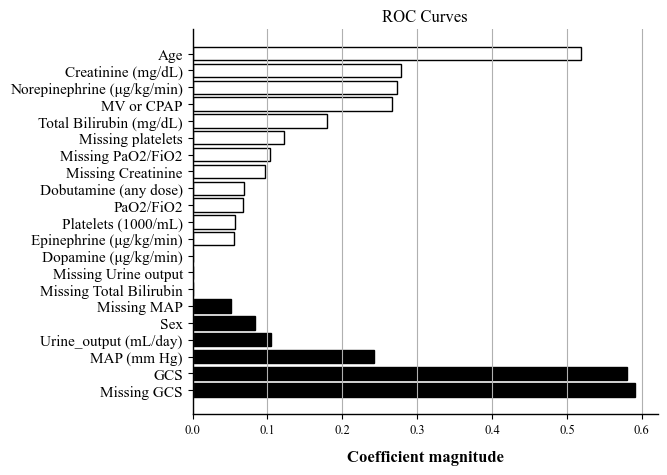

In [20]:
# Figure 2: Horizontal bar plots of coefficient value magnitudes - continued

fig, ax = plt.subplots(figsize=(6, 5)) # size is in inches

y_pos = np.arange(num_cols)
ax.barh(y_pos, np.abs(c), align = "center", color = colors, edgecolor = "black")
ax.set_yticks(y_pos, labels = column_names, fontproperties=font, size=11)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.spines['left'].set_linewidth(1)
ax.spines['bottom'].set_linewidth(1)
ax.set_xlabel('Coefficient magnitude', size=12, labelpad=10, fontweight = 'bold', fontproperties=font)
plt.title("ROC Curves", fontproperties=font, fontsize=12)

font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')

# formatting...
# plt.grid()
ax.xaxis.grid(True)
ax.spines[['right', 'top']].set_visible(False)
# ax.set_aspect('equal', 'box')

fontProperties = {'family':'sans-serif','sans-serif':['Times New Roman'],
    'weight' : 'normal', 'size' : 9}
ticks_font = font_manager.FontProperties(family='Times New Roman', style='normal',
    size=9, weight='normal', stretch='normal')
rc('font',**fontProperties)
ax.set_xticks(np.arange(0, 0.62, step=0.1))
# ax.set_yticks(np.arange(0, 1.1, step=0.2))

plt.show()
fig.savefig('Figure2.png', bbox_inches='tight', dpi=300)


In [21]:
# function to calculate calibration curves
def getCalibrationCurve(pred,Nc, y_test):
    centers = np.linspace(0.05,.95,Nc)
    cal = np.zeros((1,len(centers)))
    i=0
    for center in centers: 
        temp = np.logical_and(pred > (center-0.05), pred < (center+0.05))
        den = np.sum(temp==True)
        temp2 = np.logical_and(temp==True, y_test==1)
        num = np.sum(temp2)
        cal[0,i] = num/den
        i = i+1
    x = centers.reshape(1, len(centers))
    x = x.T
    cal = cal.T
    return x, cal

In [22]:
# function to get bootstrap confidence intervals for calibration curve
def cal_confidenceBands(pred, Nc, nb, y_test):
    
    inds = list(range(1, pred.shape[0]))
    N = len(pred)
    cal = np.zeros((nb,Nc))

    for i in range(nb):
        bootstrap_inds = np.random.choice(inds, size=len(inds), replace=True)
        x_temp, cal_temp = getCalibrationCurve(pred[bootstrap_inds],Nc, y_test[bootstrap_inds])
        cal[i,:] = cal_temp.reshape(1,len(cal_temp))
    
    x = x_temp.reshape(-1)
    # get 95% confidence interval
    U = np.percentile(cal, 97.5,axis =0)
    M = np.percentile(cal, 50,axis =0)
    L = np.percentile(cal, 2.5,axis =0)
    
    return L,M,U,x

In [23]:
# function that prepares the data for calibration of the model

def prepareDataForCalibration(pred):
    z1 = np.zeros_like(pred) 
    z2 = np.zeros_like(pred)
    z3 = np.zeros_like(pred)
    z4 = np.zeros_like(pred)
    z5 = np.zeros_like(pred)

    logits = np.log(pred/(1-pred))
    m_train = np.mean(logits)
    sd_train = np.std(logits) 
    logits = (logits - m_train) / sd_train

    mask1 = pred<0.2
    mask2 = (pred>0.2)*(pred<0.4)
    mask3 = (pred>0.4)*(pred<0.6)
    mask4 = (pred>0.6)*(pred<0.8)
    mask5 = pred>0.8

    z1[mask1] = logits[mask1]  
    z2[mask2] = logits[mask2]
    z3[mask3] = logits[mask3]  
    z4[mask4] = logits[mask4]
    z5[mask5] = logits[mask5]
    
    z = np.concatenate([z1[:,None], z2[:,None], z3[:,None], z4[:,None], z5[:,None]], axis=1) 
    
    return logits, z

In [24]:
# Calibrate the SOFA-LR model

# define 5 inputs z1, ..., z5 for a new model, to be active in regions [0,0.2], [0.2,0.4],..., [0.8,1.0]: 
pred_train, fpr, tpr, auc = LogRegressTest(X_train, y_train, N, clf0)
logits, z_train = prepareDataForCalibration(pred_train)
clf_cal = LogisticRegressionCV(cv = 5, refit=True, solver = 'liblinear',random_state = 0).fit(z_train, y_train)

# now make predictions on the testing data using the calibrated model
pred_test, fpr, tpr, auc = LogRegressTest(X_test, y_test, N, clf0)
logits_test, z_test = prepareDataForCalibration(pred_test)
pred_train_cal_test = clf_cal.predict_proba(z_test)

In [25]:
# get calibration curve for the final (calibrated) SOFA-LR model 
pred_train_cal_test, fpr, tpr, auc = LogRegressTest(z_test, y_test, N, clf_cal)
Nc = 100 
x, cal = getCalibrationCurve(pred_train_cal_test, Nc, y_test)
Lf, Mf, Uf, xf = cal_confidenceBands(pred_train_cal_test, Nc, nb, y_test)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()


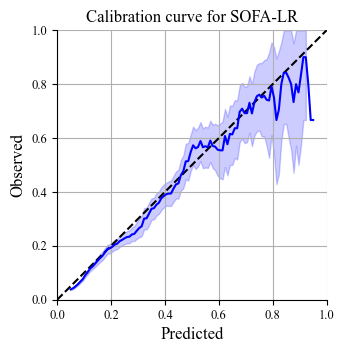

In [26]:
# plot calibration curve
fig, ax = plt.subplots(figsize=(3.5, 3.5)) # size is in inches

ax.plot([0,1], [0,1], 'k--')

fancy, = ax.plot(x, cal, 'b')
ax.fill_between(xf, Lf, Uf, alpha=0.2, color = 'b')


font = FontProperties()
font.set_family('serif')
font.set_name('Times New Roman')

# formatting...
fontProperties = {'family':'sans-serif','sans-serif':['Times New Roman'],
    'weight' : 'normal', 'size' : 9}
ticks_font = font_manager.FontProperties(family='Times New Roman', style='normal',
    size=9, weight='normal', stretch='normal')
rc('font',**fontProperties)
ax.set_xticks(np.arange(0, 1.1, step=0.2))
ax.set_yticks(np.arange(0, 1.1, step=0.2))

plt.grid()
ax.set_aspect('equal', 'box')

ax.spines[['right', 'top']].set_visible(False)
ax.set_aspect('equal', 'box')
plt.xlabel("Predicted",fontproperties=font, fontsize=12)
plt.ylabel("Observed",fontproperties=font, fontsize=12)
plt.title('Calibration curve for SOFA-LR', fontproperties=font, fontsize=12)
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.show()
fig.savefig('Figure1b.png', bbox_inches='tight', dpi=300)

In [27]:
# save the 2-stage model
import joblib
joblib.dump(clf0, 'LR_model.pkl')
joblib.dump(clf_cal, 'LR_model_cal.pkl')

['LR_model_cal.pkl']